# How Individuals clap and coordinate


Evaluate how individual participants clap per clapping round: relative intensity of claps (median?), number, median rate, duration of sustained claps, time to first clap, time of last clap

Look at how these related to conditions of clapping (for whom, interrupted or decayed) and individual survey responses (piece wise, trait wise)



 Also can we improve alignment of claps via intervals of syncrhonisation? 
 
 And if so, can we then more accuratly track the joining and leaving of synchrony?
 
 Also should we have the real time applause with audio? and video of stage

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import imageio

# dependencies
from scipy.signal import find_peaks

pd.options.mode.chained_assignment = None

In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [3]:
%reload_ext autoreload

In [4]:
def rms_signal(data, window_size, shift):
  # data is pandas Series of signal
  # function to calculate root mean square using a scrolling window.
  i = int(window_size/2)
  l = data.shape[0]
  rms_y = [np.nan]*l

  while True:
    if i >= l:
      break

    if (i >= window_size/2) and (l-i >= window_size/2):
      in_window  = int(i-window_size/2)
      out_window = int(i+window_size/2)

      data_rms = data.iloc[in_window:out_window]
      if data_rms.isna().sum() < (len(data_rms)):
        data_rms = data_rms.dropna()
      rms_value = math.sqrt(sum([i*i for i in data_rms])/len(data_rms)) if data_rms.isna().sum() == 0 else -1

    else:
      rms_value = np.nan

    rms_y[i] = rms_value
    i = i + shift

  df = pd.DataFrame(index = data.index, columns = ['rms'], data={'rms': rms_y})
  return df

def butter_lowpass_filter(data, cutoff, fs, order):
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y

# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

### file access

In [5]:
# Now to map those values to locations, need to import some details.
# these are old ID codes, need to replace. 
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

internal_mlmotion = general_loc + 'Internal/Motion_ML/'
internal_ax3 = general_loc +  'Internal/Motion_AX3/'
internal_Part = general_loc + 'Internal/Participants/'
internal_time = general_loc + 'Internal/Timing/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [6]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
partDets = partDets.loc[~partDets['X'].isna(),:]
MovingParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements

Part_Codes = list(MovingParts.Participant_Code.values)


In [7]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
#Sub_Rels

In [8]:
claps_folder = 'C:/Users/finnu/dev/copenhagen-musiclab-clapping/clapfiles/clapping_peaks/'

os.listdir(claps_folder)

['bach_applause_peaks.csv',
 'beethoven_applause_peaks.csv',
 'clapping_after_introduction_peaks.csv',
 'clapping_between_speeches_1_peaks.csv',
 'clapping_between_speeches_2_peaks.csv',
 'concert_begins_peaks.csv',
 'final_applause_peaks.csv',
 'folk_music_1_applause_peaks.csv',
 'folk_music_2_applause_peaks.csv',
 'folk_music_3_applause_peaks.csv',
 'folk_music_4_applause_peaks.csv',
 'folk_music_5_applause_peaks.csv',
 'musicians_return_1_peaks.csv',
 'musicians_return_2_peaks.csv',
 'schnittke_applause_peaks.csv',
 'Schnittke_Stage_events.csv']

# Clap extraction
take one participants movements and show how claps were extracted

In [9]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,AEQ086,86,A,E,Q,0,5.0,NaN,NaN,NaN,NaN,0.34,0.0
81,AEQ087,87,A,E,Q,1,3.0,NaN,NaN,NaN,0.12,0.28,0.0
82,AEQ088,88,A,E,Q,0,2.0,NaN,NaN,NaN,0.10,0.06,0.0
83,AEQ089,89,A,E,Q,0,4.0,NaN,NaN,NaN,0.28,0.38,0.0


In [10]:
applause_times = pd.read_csv('data/Applause_Moments.csv',sep=",") #SV alignment for beeps
applause_times

,Stream_Time,concert_time,Applause_N,Event,Event_Type
0,945.9,-688.50,0,Musicians enter hall,Musician_act
1,946.0,-688.40,0,Clapping Start,First_Clap
2,963.0,-671.40,0,Musicians seated,Musician_act
3,963.1,-671.30,0,Clapping End,Last_Clap
4,1081.0,-553.40,1,Last word V,Speach
...,...,...,...,...,...
99,9757.0,8122.60,14,Bow 5,Musician_act
100,9774.0,8139.60,14,Bow 6,Musician_act
101,9776.0,8141.60,14,Start to leave stage,Musician_act
102,9783.0,8148.60,14,Out of sight,Musician_act


In [28]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 50 Hz
ts_ct = np.arange(-1086,9715, 0.02)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Concert_Events_On_Off.csv',sep=",") #SV alignment for beeps
concert_times['sequence'] = concert_times.index
concert_times.set_index('Time_dt_Start',inplace = True)
concert_times.iloc[:5]

concert_applause = concert_times.loc[concert_times['Event_Type']=='Applause',:]
# music preceding Claps 4, 6, 8, 10-15
concert_applause

df_clappings = pd.DataFrame(columns = ['section_id','start_time_concert','start_time','end_time_concert','end_time','tag','clapping_type'])
tags = ['Concert begins','Clapping Between Speeches 1','Clapping After Introduction','Beethoven Applause','Musicians Return 1','Schnittke Applause','Musicians Return 2','Bach Applause','Folk Music 1 Applause','Folk Music 2 Applause','Folk Music 3 Applause','Folk Music 4 Applause','Folk Music 5 Applause','Clapping Between Speeches 2','Final Applause']
# cue_tags = ['Musicians Enter Hall','Last word','Last word','Last Note' ]
# cue_time = [-694.50,-558.24,29.46,1607.21,]
df_clappings['section_id'] = range(len(tags))
df_clappings['start_time_concert'] = concert_applause['Time_s_Start'].values
df_clappings['start_time'] = concert_applause['Time_Stream_Start'].values
df_clappings['end_time_concert'] = concert_applause['Time_s_End'].values
df_clappings['end_time'] = concert_applause['Time_Stream_End'].values
df_clappings['tag'] = tags
df_clappings['clapping_type'] = [1,1,1,2,1,2,1,2,3,3,3,3,3,1,4]
df_clappings

,section_id,start_time_concert,start_time,end_time_concert,end_time,tag,clapping_type
0,0,-693.24,946.00,-676.16,963.08,Concert begins,1
1,1,-558.04,1081.20,-550.12,1089.12,Clapping Between Speeches 1,1
2,2,28.44,1667.68,38.36,1677.60,Clapping After Introduction,1
3,3,1608.52,3247.76,1649.88,3289.12,Beethoven Applause,2
4,4,2002.68,3641.92,2014.46,3653.70,Musicians Return 1,1
5,5,3280.54,4919.78,3340.98,4980.22,Schnittke Applause,2
6,6,4999.90,6639.14,5017.56,6656.80,Musicians Return 2,1
7,7,6017.66,7656.90,6039.78,7679.02,Bach Applause,2
8,8,6757.04,8396.28,6774.54,8413.78,Folk Music 1 Applause,3
9,9,6931.24,8570.48,6950.80,8590.04,Folk Music 2 Applause,3


In [29]:
concert_times

,Event,Time_s_Start,Time_ms_Start,Time_Stream_Start,Time_dt_End,Time_s_End,Time_ms_End,Time_Stream_End,sequence,Event_Duration,Event_Type
Time_dt_Start,,,,,,,,,,,
2021-10-26 17:36:32.760,Claps 1,-693.24,-693240.0,946.00,2021-10-26 17:36:49.840,-676.16,-676160.0,963.08,0,17.08,Applause
2021-10-26 17:36:50.820,MC Speach 1,-675.18,-675180.0,964.06,2021-10-26 17:38:47.780,-558.22,-558220.0,1081.02,1,116.96,Speach
2021-10-26 17:38:47.960,Claps 2,-558.04,-558040.0,1081.20,2021-10-26 17:38:55.880,-550.12,-550120.0,1089.12,2,7.92,Applause
2021-10-26 17:38:53.840,MC Speach 2,-552.16,-552160.0,1087.08,2021-10-26 17:48:18.380,12.38,12380.0,1651.62,3,564.54,Speach
2021-10-26 17:47:58.840,Synch cue 1,-7.16,-7160.0,1632.08,2021-10-26 17:48:35.460,29.46,29460.0,1668.70,4,36.62,Synchronisation
2021-10-26 17:48:34.440,Claps 3,28.44,28440.0,1667.68,2021-10-26 17:48:44.360,38.36,38360.0,1677.60,5,9.92,Applause
2021-10-26 17:49:01.400,Music Beethoven 1,55.40,55400.0,1694.64,2021-10-26 17:55:41.840,455.84,455840.0,2095.08,6,400.44,Music
2021-10-26 17:56:00.260,Music Beethoven 2,474.26,474260.0,2113.50,2021-10-26 17:59:17.180,671.18,671180.0,2310.42,7,196.92,Music
2021-10-26 17:59:45.340,Music Beethoven 3,699.34,699340.0,2338.58,2021-10-26 18:07:17.820,1151.82,1151820.0,2791.06,8,452.48,Music


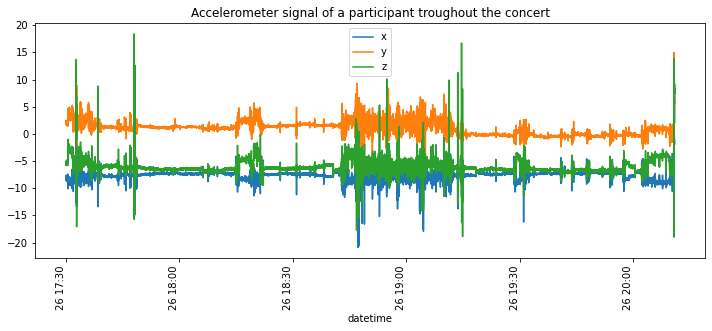

In [30]:
i = 11
participant = alignedParts.loc[i,:]

part = participant['Participant_Code']
if part[2]=='Q': # Motionlab phone acc
    inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
else: # AX3
    inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format


inst_d.plot(x='datetime', y=['x','y','z'], figsize=(12,4.8), title='Accelerometer signal of a participant troughout the concert')
plt.xticks(rotation=90)
plt.show()

In [31]:
# transfer to a consistent samples rate
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 100
datas = gap_nans(inst_d,gap_t)
#get concert time
resampled = pd.DataFrame(index = ts_ct)
cols = datas.columns
for col in cols[1:]:
    f = interp1d(datas['time'], datas[col],fill_value='extrapolate')
    resampled[col] = f(ts_ct)

# extract 1D accelerometer feature for easy comparison
# and basic normalisation
b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
if part[2]=='Q':
    aud_df[part] = b
else:
    aud_df[part] = b*8
aud_df.index = dt_ct

In [12]:
full_motion_50hz_df = aud_df.copy()
full_motion_50hz_df.index = ts_ct

In [13]:
df_clappings.loc[14]

section_id                        14
start_time_concert           8040.24
start_time                   9679.48
end_time_concert             8147.28
end_time                     9786.52
tag                   Final Applause
clapping_type                      4
Name: 14, dtype: object

In [32]:
# low pass filter
T = 10.0        # sample period
fs = 50.0       # Hz
cutoff = 12.5   # cutoff frequency of the filter # Hz
nyq = 0.5 * fs  # nyquist frequency
order = 2 
n = int(T * fs)

#for ev_idx in df_clappings['section_id']:
ev_idx = 14
ev_in, ev_out, ev_type, ev_tag = df_clappings.loc[ev_idx, ['start_time_concert', 'end_time_concert', 'clapping_type', 'tag']]

extend = 0
in_event_time = (ev_in - extend) * 10**3
out_event_time = (ev_out + extend) * 10**3
   
df_seg = full_motion_50hz_df.loc[in_event_time:out_event_time]
df_seg_ind = np.round(df_seg.index) 
print('section:', ev_tag, (in_event_time, out_event_time),len(df_seg))

ts_ev = np.round(df_seg.index - df_seg.index[0]) # not in date time for now, just ms
df_section = pd.DataFrame(index = ts_ev,columns = aud_df.columns)
for dev_n in df_seg.columns:
    #print('   ', dev_n)
    df_clap = df_seg.loc[:,dev_n]
    data_raw = df_clap[~np.isnan(df_clap)]
    if data_raw.shape[0] > 10:
        data_filtered = butter_lowpass_filter(data_raw, cutoff, fs, order)
    else:
        #data_raw[f.split('.')[0]] = np.nan
        data_filtered = data_raw
df_clap.loc[data_raw.index] = data_filtered
# save clapping interval as df
df_section[dev_n] = df_clap.values
#df_section.index = pd.to_datetime(df_section.index, unit='ms').strftime('%H:%M:%S.%f')
df_section.index = pd.to_datetime(df_seg_ind, unit='ms').strftime('%H:%M:%S.%f')
df_section.index.name = 'index'
df_section

section: Final Applause (8040240.0, 8147280.000000001) 5352


,ADQ012
index,
02:14:00.260000,0.093022
02:14:00.280000,0.091304
02:14:00.300000,0.091572
02:14:00.320000,0.090472
02:14:00.340000,0.084024
...,...
02:15:47.200000,0.091971
02:15:47.220000,0.125609
02:15:47.240000,0.148157


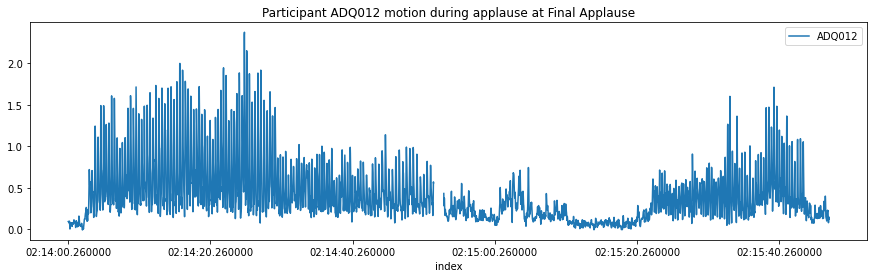

In [33]:
df_section.plot(figsize=[15,4])
plt.title('Participant ' + part + ' motion during applause at ' + ev_tag)
plt.show()

In [34]:
df_motion =df_section.copy()
df_motion.index = pd.Series(np.arange(0,len(df_motion.index))*0.02)
df_ev = df_motion.copy()

# create csv files
df_trimmed = pd.DataFrame(index=df_ev.index)
df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
df_rms = pd.DataFrame(columns=df_ev.columns)


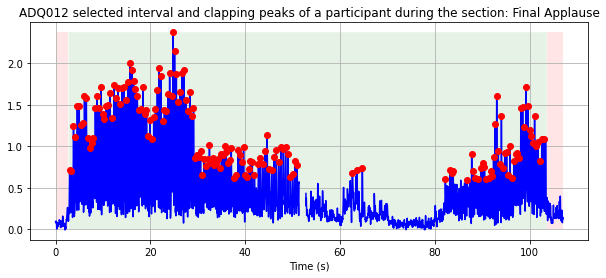

In [35]:
col = part
fs = 50
extend_ind = 4*fs
seg_len=len(df_motion)

# create csv files
df_trimmed = pd.DataFrame(index=df_ev.index)
df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
df_rms = pd.DataFrame(columns=df_ev.columns)

rms = rms_signal(df_section[part], fs, 4).dropna().replace(-1,np.nan)
std = np.std(df_ev[col])
thr = rms.mean()[0] + std*0.35
thr = 0 if np.isnan(thr) else thr
std_thr = 0.08
# discard if std of signal is below std_thr
thr = 0 if std<=std_thr else thr
# save rms
df_rms[col] = rms

# in out pins
# Extends the window 10 timestamps at both ends
extend = 10 * 0.02
if not (thr == 0):
    in_  = df_ev[df_ev[col]>thr][col].index.values[ 0] - extend
    out_ = df_ev[df_ev[col]>thr][col].index.values[-1] + extend
else:
    in_  = 0
    out_ = 0
df_ev.loc[:in_,col] = np.nan
df_ev.loc[out_:,col] = np.nan

# peaks
peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
# cut the peaks outside of the clapping range (not peaks because not audible in audio)
#peak_index_list=peak_index_list[peak_index_list>extend_ind]
peak_index_list=peak_index_list[peak_index_list<seg_len-extend_ind]

s_plot = df_ev[col].iloc[peak_index_list]
s_plot = s_plot[s_plot>thr]

# trim first and last peaks, + extend
# Extends the window 10 timestamps at both ends after trimming the
# signal based on first and last claps
if not s_plot.notna().sum() == 0:
    if s_plot.notna().sum()/df_motion.index[-1] <4:
        in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
        out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
        in_peak_dt = pd.to_datetime(in_peak).strftime('%H:%M:%S.%f')
        out_peak_dt = pd.to_datetime(out_peak).strftime('%H:%M:%S.%f')
        df_ev.loc[:in_peak,col] = np.nan
        df_ev.loc[out_peak:,col] = np.nan

# write to df
df_trimmed[col] = df_ev[col].values
df_peaks.loc[:,col] = np.nan
df_peaks.loc[s_plot.index,col] = s_plot.values

#   # plot
plt.figure(figsize = [10,4])
i = -1 # participant idx
plt.plot(df_motion.loc[:,col], 'b-', df_peaks.loc[:,col], 'ro')

if df_peaks.loc[:,col].sum()>0:

    plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                   where=(df_trimmed.index>=in_)&(df_trimmed.index<=out_), fc='g', alpha=0.1)
    plt.fill_between(df_ev.index, df_peaks.loc[:,col].max(),
                   where=(df_trimmed.index<=in_)|(df_trimmed.index>=out_), fc='r', alpha=0.1)
    if thr == 0:
        plt.ylim(100)
        plt.axhline(thr_list[i], c='r', lw=2)
        plt.gcf().set_size_inches(24,4.8)

plt.title(col + ' selected interval and clapping peaks of a participant during the section: ' + ev_tag)
plt.xlabel('Time (s)')
plt.grid()
plt.show()



In [47]:
df_ev[df_ev[col]>thr][col].index.values[0]

7.42

## rates 

In [ ]:
peaks = pd.read_csv(claps_folder + 'final_applause_peaks.csv',index_col=0)
peaks = peaks.fillna(0)
#peaks.drop(columns=['index'],inplace = True)
peaks_IDs = peaks.columns
ts = pd.Series(np.arange(0,len(peaks))*0.02)
df_claps = pd.DataFrame(index = ts,data = peaks.values)
df_claps.plot(figsize = [12,3],legend = False)
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
plt.ylim([0,10])
plt.show()

# drop the clap amplitude for simpler analysis and count claps per participant
df_OnlyClaps = df_claps.astype(bool).astype(int)
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()